In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


In [2]:
figformat = 'svg'

In [4]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'
path_local = '/home/katrin/Documents'

try:
    models = Models.read(f"{path_crab}/standard_model.yml")
    dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')

except:
    models = Models.read(f"{path_local}/{source}/standard_model.yml")
    dataset_load = MapDataset.read(f'{path_local}/{source}/stacked.fits')

dataset_load = dataset_load.downsample(4)
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

dataset_load.models = models
dataset_load.counts = dataset_load.npred()

In [5]:
biass = [0.0, 0.1, 0.2]
sigmass = [0.0]
bias = 0.5
sigma = 0.5

In [13]:
def create_dataset(b, s):
    sys_d_cor = sys_dataset(dataset_asimov= dataset_load,
                        shift = 0,
                        tilt = 0,
                        bias = b, 
                        sigma = s,
                        rnd = False)
    dataset_conv = sys_d_cor.create_dataset()
    dataset_conv_N = sys_d_cor.create_dataset_N()
    dataset_conv_N.models.parameters['norm_nuisance'].frozen  = True
    dataset_conv_N.models.parameters['tilt_nuisance'].frozen  = True
    dataset_conv_N.models.parameters['bias'].frozen  = False
    dataset_conv_N.models.parameters['resolution'].frozen  = True
    
    zero = 1e-12
    b_ = zero if b ==0 else b
    s_ = zero if s ==0 else s
    penalising_invcovmatrix = np.zeros((4, 4))
    np.fill_diagonal(penalising_invcovmatrix, [1/zero**2, 1/zero**2, 1/b_**2, 1/s_**2])
    dataset_conv_N.penalising_invcovmatrix = penalising_invcovmatrix
    return dataset_conv, dataset_conv_N
datasets_conv = []
datasets_conv_N = []

for b in biass:
    for s in sigmass:
        d = create_dataset(b,s )
        datasets_conv.append(d[0])
        datasets_conv_N.append(d[1])
        


In [14]:
def sum_e (data):
    return data.sum(axis=2).sum(axis=1)

eaxis_standard = dataset_load.geoms['geom'].axes[0]

corr
0
1
2
CPU times: user 3min 39s, sys: 7.02 s, total: 3min 46s
Wall time: 3min 46s


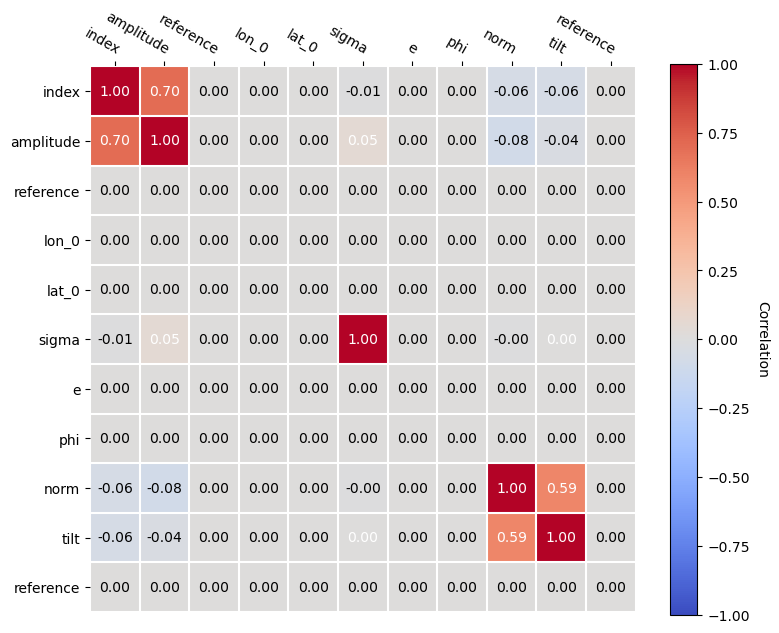

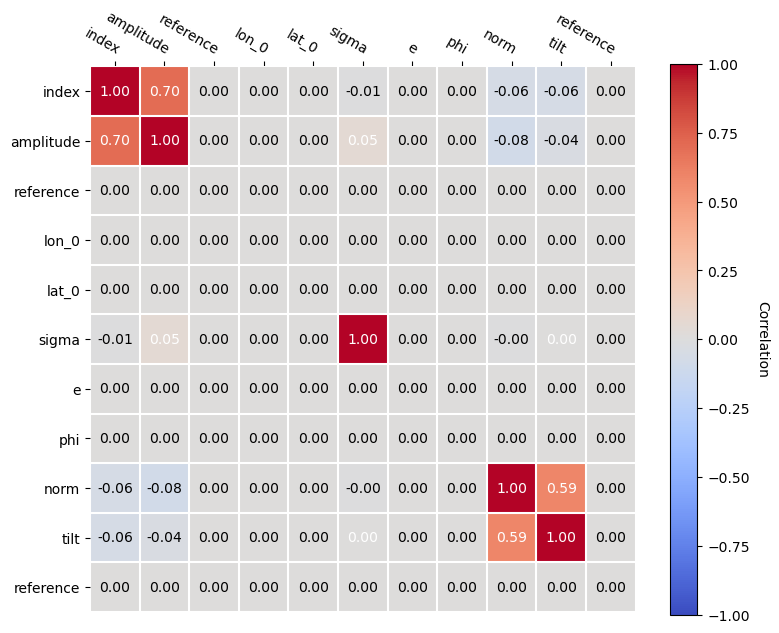

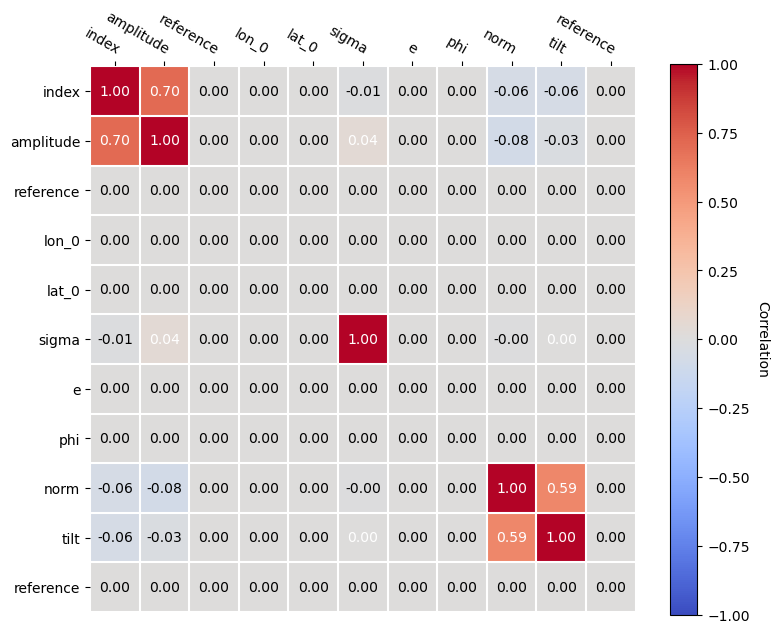

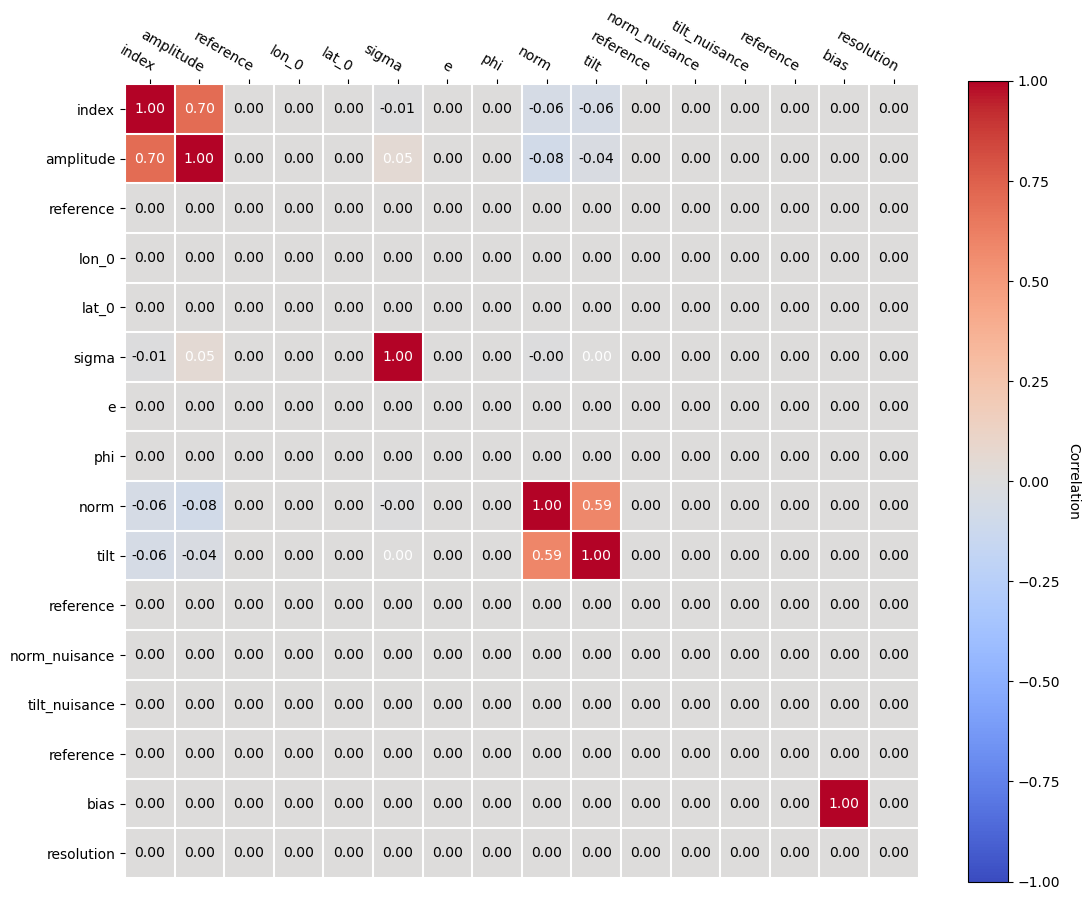

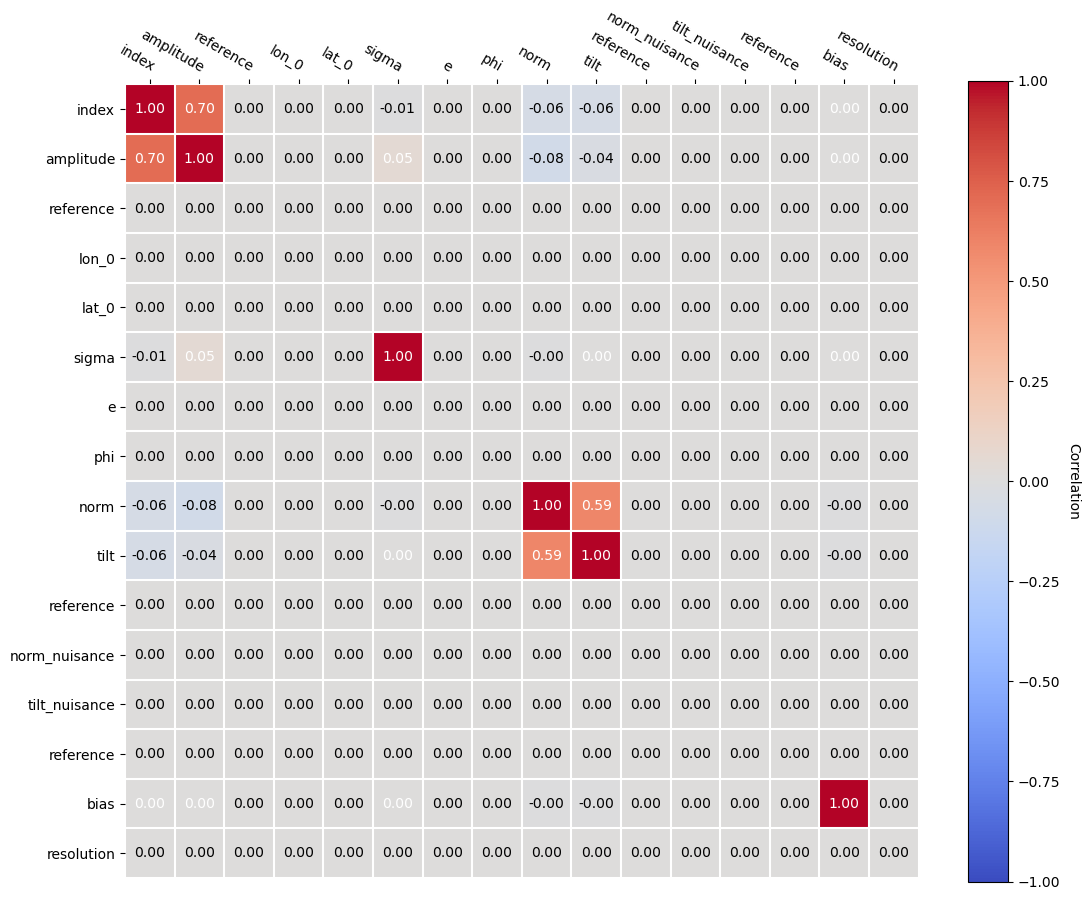

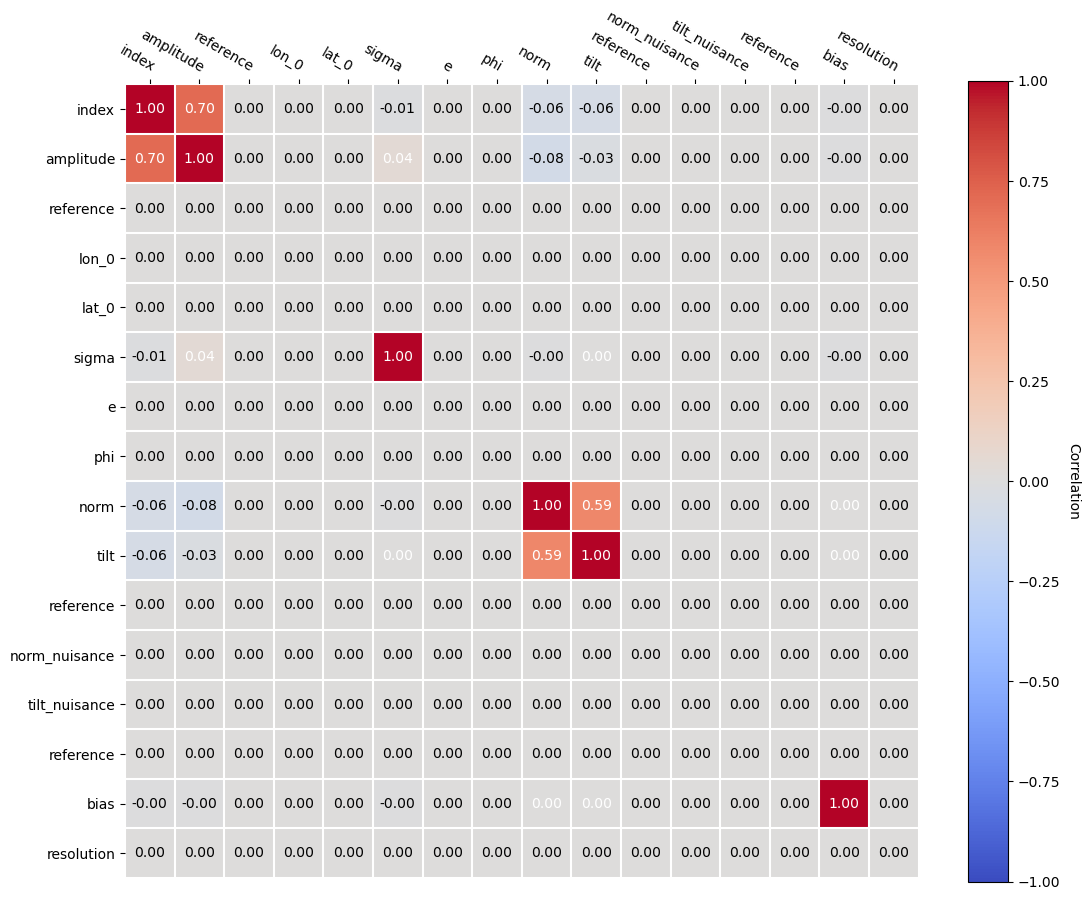

In [15]:
%%time
print("corr")
fit_cor = Fit(store_trace=False)
for d in datasets_conv:
    result_cor = fit_cor.run(d)
    d.models.covariance = fit_cor.covariance(d).matrix
    d.models.covariance.plot_correlation()
    
for i, d in enumerate(datasets_conv_N):
    print('==============')
    print(i)
    print('==============')
    result_cor = fit_cor.run(d)
    d.models.covariance = fit_cor.covariance(d).matrix
    d.models.covariance.plot_correlation()
    




        

In [17]:
for d in datasets_conv_N:
    for p in d.models.parameters.penalised_parameters:
        p.frozen = True

In [18]:
colors_standard = ['darkblue', 'sienna', 'darkolivegreen', 'darkred']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


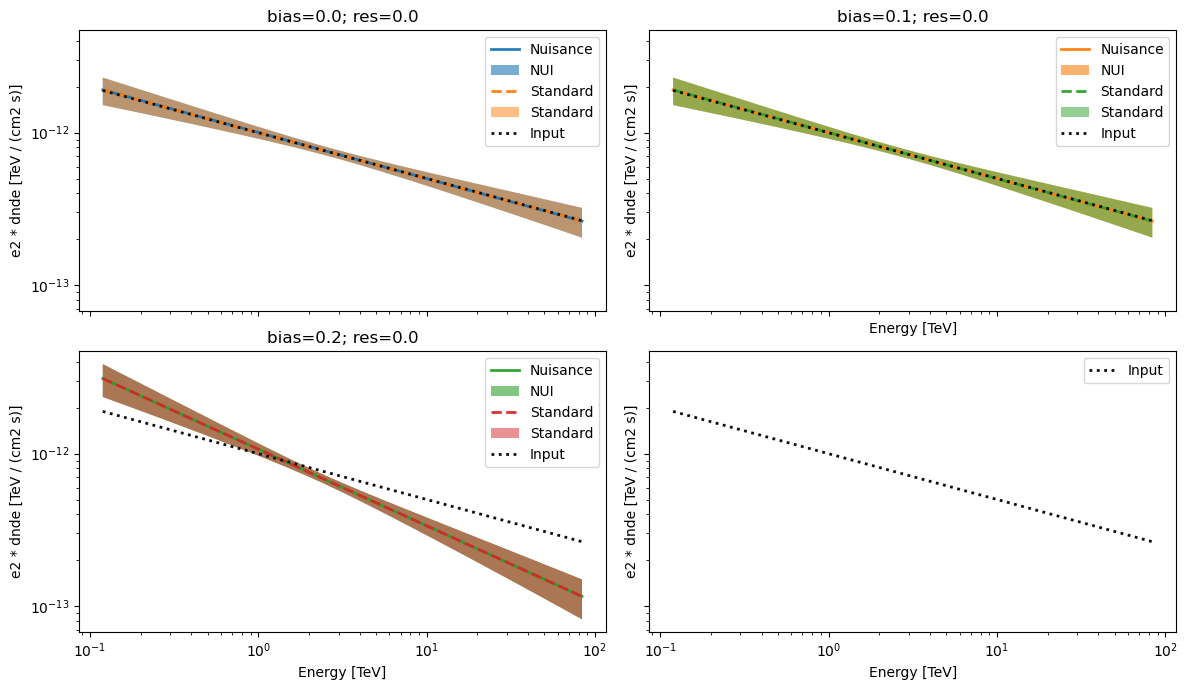

In [19]:
energy = datasets_conv[0].counts.geom.axes[0].center.value
energy_bounds = (energy[0], energy[-1] ) * u.TeV


fig,axs = plt.subplots(2,2, sharex = True, sharey=True, figsize = (12,7))
axs = axs.flatten()
i =0; ii =0
for b in biass:
    for s in sigmass:
        
        d = datasets_conv_N[i]
    
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               color=colors[ii],
                                                                 label= f"Nuisance",
                                                                alpha = 0.95,
                                                               linestyle='-', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               facecolor=colors[ii],
                                                                 label="NUI",
                                                                alpha = 0.6)
        d = datasets_conv[i]
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               color=colors[ii+1],
                                                                 label= f"Standard",
                                                                alpha = 0.95,
                                                               linestyle='--', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               facecolor=colors[ii+1],
                                                                 label="Standard",
                                                                alpha = 0.5)
        
        axs[ii].set_title(f"bias={b}; res={s}")
        i +=1
        ii +=1
for a in axs:
    dataset_load.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = a,
                                                               color='black',
                                                                 label="Input",
                                                                alpha = 0.95,
                                                               linestyle=':', linewidth= 2)  
    a.legend()
    
ylim = axs[0].get_ylim()
axs[1].set_ylim(ylim[0], ylim[1])
axs[0].set_xlabel('')
plt.tight_layout()
#fig.savefig(f"plots/1_Spectrum_bias={bias}sigma={sigma}."+figformat)

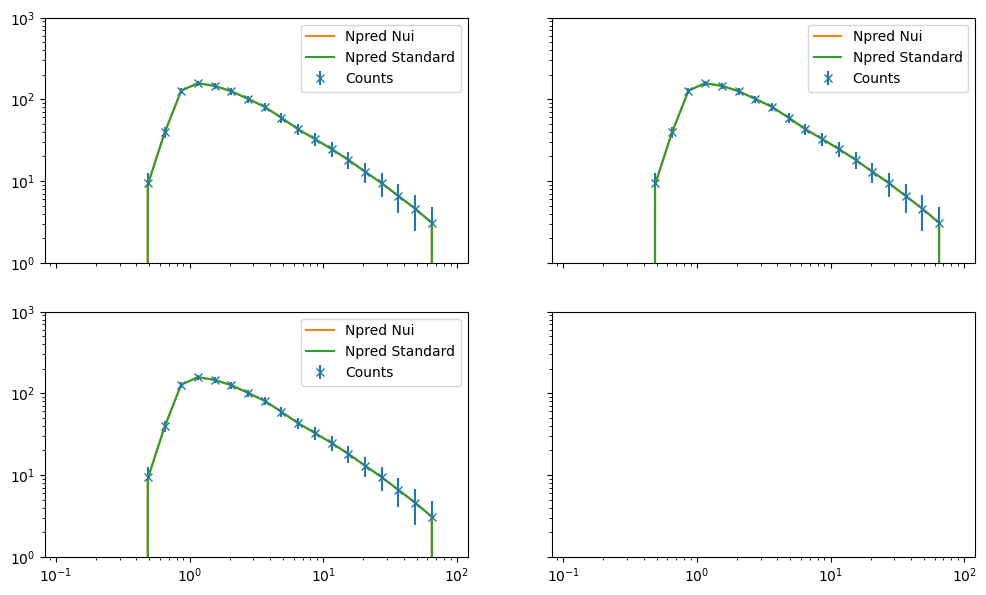

In [20]:
fig,axs = plt.subplots(2,2, sharex = True, sharey=True, figsize = (12,7))
axs = axs.flatten()
i =0; ii =0
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        axs[ii].errorbar(energy, sum_e(d.counts.data-d.background.data), 
                     yerr = np.sqrt(sum_e(d.counts.data-d.background.data)),
                    fmt = 'x', label = "Counts")

        axs[ii].plot(energy, sum_e(d.npred_signal().data), label = "Npred Nui")
        d = datasets_conv[i]
        axs[ii].plot(energy, sum_e(d.npred_signal().data), label = "Npred Standard")
        
        axs[ii].loglog()
        axs[ii].legend()
        axs[ii].set_ylim(1e0, 1e3)        
        ii +=1
        


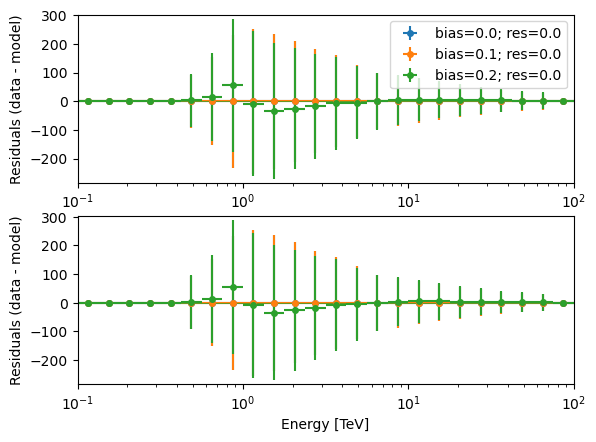

In [21]:
fig, ax = plt.subplots(2,1)
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax[0], color= colors[i], 
                    label = f"bias={b}; res={s}")
        d = datasets_conv[i]
        d.plot_residuals_spectral(ax =ax[1], color= colors[i], 
                    label = f"bias={b}; res={s}")
        i += 1
ax[0].legend()


['B=0.0;\n R=0.0', 'B=0.1;\n R=0.0', 'B=0.2;\n R=0.0']


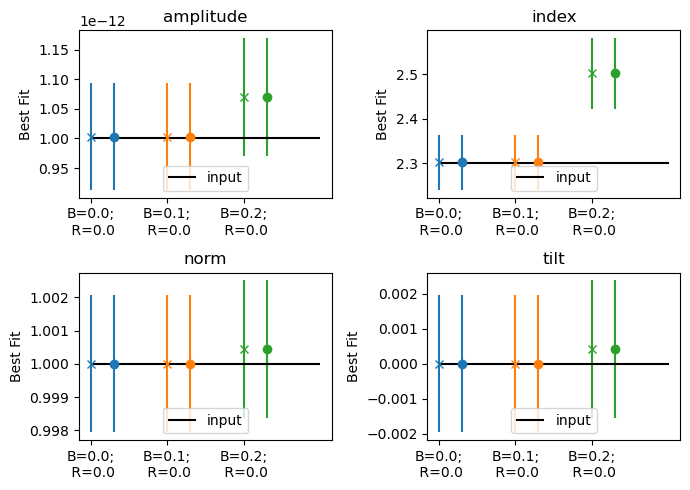

In [22]:
fig,ax  = plt.subplots(2,2,figsize= (7, 5))
ax = ax.flatten()
parnames = ['amplitude', 'index', 'norm', 'tilt']
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'x', color = colors[ii])
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii+0.3, value, yerr = error, fmt = 'o', color = colors[ii])
        ii +=1
        labels_sys.append(f'B={b};\n R={s}')
print(labels_sys)        
for i, p in enumerate(parnames):
    value = dataset_load.models.parameters[p].value
    error = dataset_load.models.parameters[p].error    
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, 3, label = "input", color= 'black')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='lower center',)# bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    #ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(len(datasets_conv)),labels_sys)
    
plt.tight_layout()
    

['B=0.0;\n R=0.0', 'B=0.1;\n R=0.0', 'B=0.2;\n R=0.0']


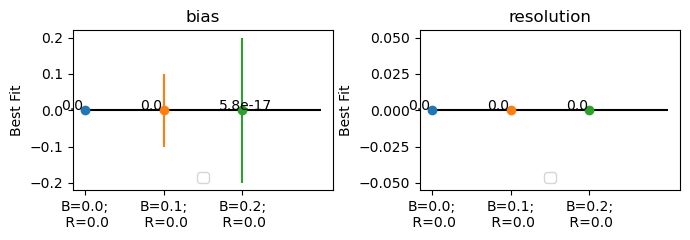

In [23]:
fig,ax  = plt.subplots(1,2,figsize= (7, 2.5))
ax = ax.flatten()
parnames = ['bias', 'resolution',]
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'o', color = colors[ii])
            ax[i].set_title(p)
            ax[i].text(ii-0.3, 0, f'{value:.3}')
        ii +=1
        labels_sys.append(f'B={b};\n R={s}')
        
print(labels_sys)        
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='lower center',)# bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    #ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(len(datasets_conv)),labels_sys)
    ax.hlines( 0, 0., 3., label = "input", color= 'black')
    
plt.tight_layout()
    

In [25]:
ii =0
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        for i, p in enumerate(['bias']):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error   
            print(value , "pm", error)
            ii+=1

0.0 pm 1e-12
0.0 pm 0.10000000000092628
5.79526219666827e-17 pm 0.20000000000979176


In [ ]:
# in error propagation of model, the irf model does not get evaluated. Want to have the error intrinsically within the 